# Machine Learning Pipeline for Fatigue Prediction in the full IBD Cohort

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = 1337  # Random seed to ensure reproducibility
output_path = "output/tensorflow_biochem_remission/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
# file_prefix="tensorflow"
file_prefix = "biochem_remission"

In [3]:
plt.rcParams['font.family'] = 'Roboto'

## Data Loading

In [4]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [5]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})

In [6]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [8]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


In [9]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (178, 79)
Val shape: (41, 79)
Test shape: (48, 79)


In [10]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
    "disease_duration_weeks",
]
train_scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
train_scaler.fit(X_train[numerical_features])
X_train[numerical_features] = train_scaler.transform(X_train[numerical_features])

test_scaler = StandardScaler()
test_scaler.fit(X_test[numerical_features])
X_test[numerical_features] = test_scaler.transform(X_test[numerical_features])

val_scaler = StandardScaler()
val_scaler.fit(X_val[numerical_features])
X_val[numerical_features] = val_scaler.transform(X_val[numerical_features])


## Deep Learning with TensorFlow


### Model Definition

In [11]:
model = keras.Sequential(
    [
        layers.Dense(85, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(85, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="auc", patience=10, restore_best_weights=True)

### Compiling the Model

In [12]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

In [13]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback, tensorboard_callback],
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.5394 - loss: 0.7892 - val_auc: 0.7194 - val_loss: 0.5275
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6823 - loss: 0.5558 - val_auc: 0.7597 - val_loss: 0.4980
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6458 - loss: 0.5821 - val_auc: 0.7935 - val_loss: 0.4833
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6875 - loss: 0.5707 - val_auc: 0.8290 - val_loss: 0.4715
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6596 - loss: 0.5796 - val_auc: 0.8419 - val_loss: 0.4607
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7796 - loss: 0.5257 - val_auc: 0.8645 - val_loss: 0.4498
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6967 - loss: 0.5691 - val_auc: 0.8661 - val_loss: 0.4438
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7831 - loss: 0.5251 - val_auc: 0.8516 - val_loss: 0.4386
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8177 - loss: 0.4901 -

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 85)             │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 85)             │         7,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            86 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,394 (110.92 KB)

 Trainable params: 14,196 (55.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,198 (55.46 KB)

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

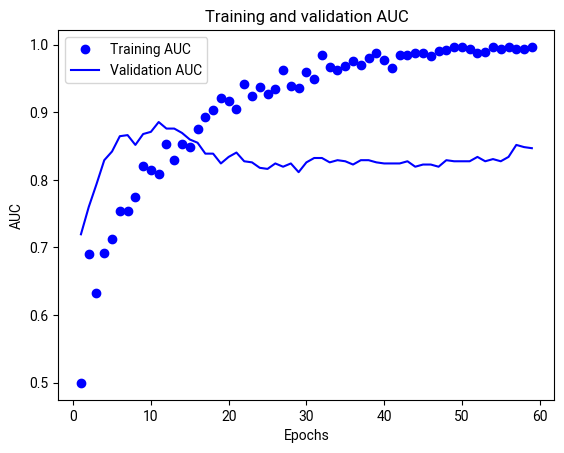

In [16]:
auc_values = history_dict["auc"]
val_auc_values = history_dict["val_auc"]
epochs = range(1, len(auc_values) + 1)
plt.plot(epochs, auc_values, "bo", label="Training AUC")
plt.plot(epochs, val_auc_values, "b", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_loss.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

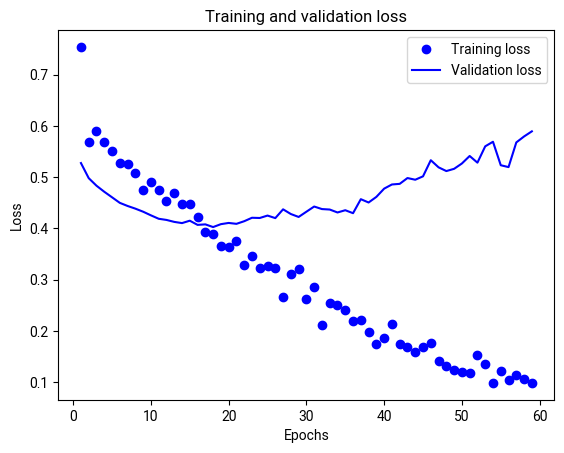

In [17]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_loss.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

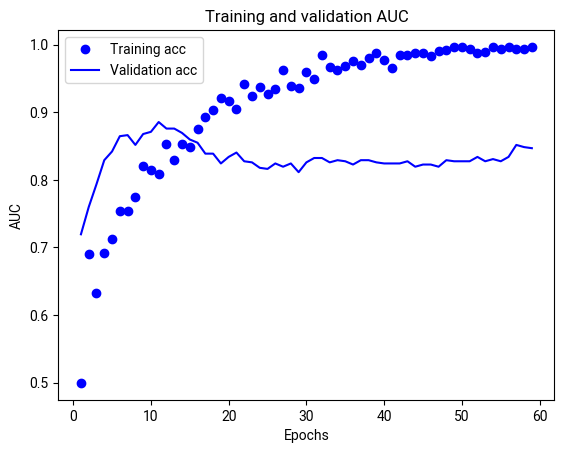

In [18]:
plt.clf()
acc = history_dict["auc"]
val_acc = history_dict["val_auc"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
save_path = output_path + file_prefix + "_training_vs_validation_auc.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [19]:
results = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - loss: 0.2785


In [20]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1,0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9166666666666666
Sensitivity: 0.75
Specificity: 0.9722222222222222
AUC: 0.8981481481481481


In [21]:
np.savetxt(output_path + "dnn_fpr.txt", fpr)
np.savetxt(output_path + "dnn_tpr.txt", tpr)

with open(output_path + "dnn_auc.txt", "w") as f:
    f.write(str(test_auc))

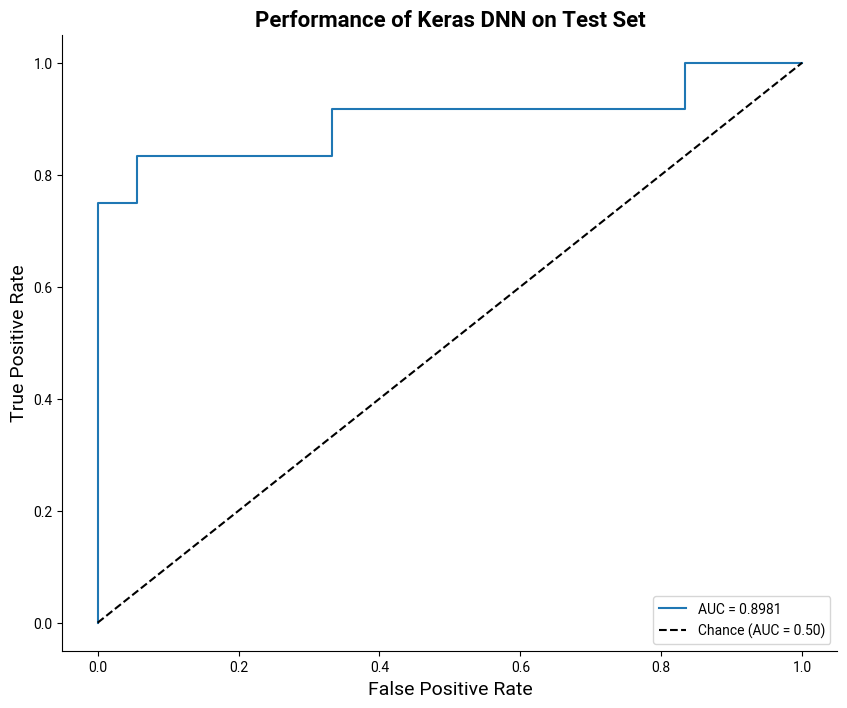

In [22]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr,
    label=f"AUC = {test_auc:.4f}",
)

# Add baseline and plot details
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Performance of Keras DNN on Test Set", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")

# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define the absolute path
save_path = f"{output_path}{file_prefix}_roc_curves.png"

# Save the plot to the specified path
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

## View Tensorboard Output

To launch tensorboard run the following in terminal:

```bash
tensorboard --logdir logs/
```

## SHAP Analysis on Keras DNN Model

In [23]:
X_test_clean_columns = [col.replace("montreal_cd_location_", " ") for col in X_test.columns]
X_test_clean_columns = [col.replace("_", " ") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("montreal uc extent ", "") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("montreal cd behaviour ", "") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("name ", "") for col in X_test_clean_columns]
# to title case
X_test_clean_columns = [col.title() for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Uc", "UC") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Bmi", "BMI") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("Crp", "CRP") for col in X_test_clean_columns]
print(X_test_clean_columns)

['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Age At Diagnosis', 'Montreal Upper Gi', 'Montreal Perianal', 'Baseline Eims Arthralgia Arthritis', 'Baseline Eims Ankylosing Spondylitis', 'Baseline Eims Erythema Nodosum', 'Baseline Eims Uveitis', 'Baseline Eims Scleritis Episclerities', 'Has Active Symptoms', 'Albumin', 'CRP', 'Haemoglobin', 'Red Cell Count', 'Haematocrit', 'White Cell Count', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'Basophils', 'Platelets', 'Urea', 'Creatinine', 'Sodium', 'Potassium', 'Calprotectin', 'Ada Drug Level', 'Ifx Drug Level', 'Sampling Steroids', 'Sampling Abx', 'Sampling Asa', 'Sampling Aza', 'Sampling Mp', 'Sampling Ifx', 'Sampling Ada', 'Sampling Vedo', 'Sampling Uste', 'Sampling Tofa', 'Sampling Mtx', 'Sampling Ciclosporin', 'Sampling Filgo', 'Sampling Upa', 'Sampling Risa', 'Ifx Antibody Present', 'Ada Antibody Present', 'Disease Duration Weeks', 'Diagnosis Year', 'Ada Drug Level Present', 'Ifx Drug Level Present', 'Study Group Await Dx', 'S

In [24]:
explainer = shap.KernelExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

100%|██████████| 48/48 [00:08<00:00,  5.78it/s]


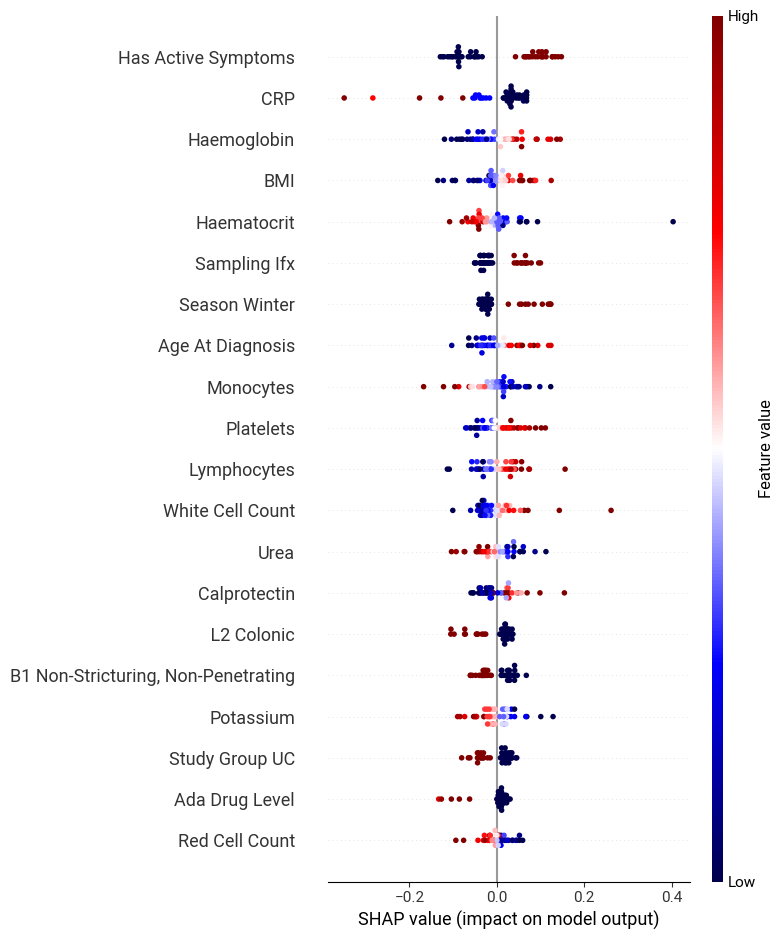

In [37]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
)

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

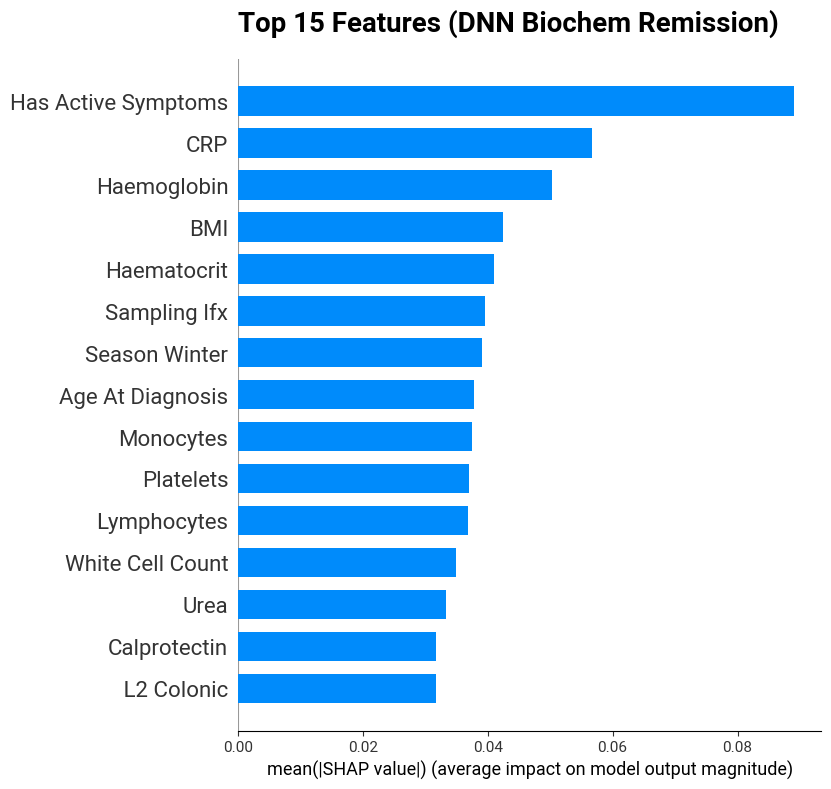

In [43]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=15,
)
plt.title("Top 15 Features (DNN Biochem Remission)", fontsize=20, pad=20, loc="left", fontweight="bold")
plt.yticks(fontsize=16)


save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()

In [27]:
shap.initjs()

In [28]:
X_test_reverted = X_test

In [29]:
X_test_reverted[numerical_features] = test_scaler.inverse_transform(X_test[numerical_features])

In [30]:
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

In [31]:
patient = 6

for i in range(40):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_class_1[i],
        X_test_reverted.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


## SHAP Deep Explainer

Deep explainer is much faster than kernel explainer to compute
However it is an approximation and therefore it's results are not the same as kernel explainer

In [32]:
# X_train_sample = shap.sample(X_train, 100)

# X_train_sample_np_array = X_train_sample.to_numpy()
# deep_explainer = shap.DeepExplainer(model, X_train_sample_np_array)
# shap_values = deep_explainer.shap_values(X_train_sample_np_array, output_rank_order="max_abs")

In [33]:
# shap_values_class_1 = shap_values[:, :, 0]
# shap.summary_plot(
#     shap_values_class_1,
#     X_train_sample,
#     feature_names=X_train_sample.columns,
#     show=False,
#     cmap=cmap,
# )

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

# # save_path = f"{output_path}shap_keras_dnn.png"
# # plt.savefig(save_path, dpi=300, bbox_inches="tight")
# plt.show()

In [34]:
# Find incorrect predictions

outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]

incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)
incorrect_predictions.to_csv( f"{output_path}forceplots/incorrect_predictions/incorrect_predictions.csv", index=False)
shap_values_incorrect_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[incorrect_predictions.index]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

In [35]:
for i in len(shap_values_incorrect_predictions):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/incorrect_predictions/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")

TypeError: 'int' object is not iterable